<h1 align='center'> Toxic Comments Classification <h1>

<h2 align='right'> Euiyoung (Jim) Chung <h2>


## Descriptions:

You are provided with a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:

toxic<br>
severe_toxic<br>
obscene<br>
threat<br>
insult<br>
identity_hate<br>
<br>

You must create a model which predicts a probability of each type of toxicity for each comment.





## Table of Contents:

1. Data Import 
2. Exploratory Data Analysis
3. Feature Engineering
4. Trying Multiple Models

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from string import punctuation

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import re, string

plt.style.use('seaborn-whitegrid')
%matplotlib inline

<br>
## Data Import

In [2]:
ls

kensho_learn/               train.csv
toxic_classification.ipynb


In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
pd.options.display.max_colwidth = 100
df['comment_text'].head(20)

0     Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They wer...
1     D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, Januar...
2     Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relev...
3     "\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics...
4                                     You, sir, are my hero. Any chance you remember what page that's on?
5                                     "\n\nCongratulations from me as well, use the tools well.  · talk "
6                                                            COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
7     Your vandalism to the Matt Shirvington article has been reverted.  Please don't do it again, or ...
8     Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything i...
9                                  alignment o

In [6]:
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

<br>
## Exploratory Analysis

In [7]:
# 0: clean, 1: toxic
df['isToxic'] = 1-(df.iloc[:,3:].sum(axis=1) == 0)

In [8]:
df['str_len'] = df['comment_text'].str.len()

In [9]:
print("Is evry id unique?:", len(df['id'].unique()) == len(df))

Is evry id unique?: True


In [10]:
df.groupby(['isToxic'])['str_len'].mean()

isToxic
0    401.840355
1    284.460934
Name: str_len, dtype: float64

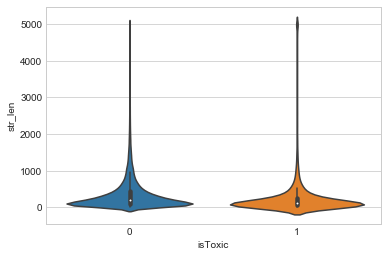

In [11]:
sns.violinplot('isToxic', 'str_len', data=df)

In [12]:
# Non-parametric two-sample t-test. Significant difference under 99% confidence level.
from scipy.stats import kruskal
kruskal(df.loc[df['isToxic']==0, 'str_len'], df.loc[df['isToxic']==1, 'str_len'])

KruskalResult(statistic=2454.691571254291, pvalue=0.0)

In [13]:
def count_upper(txt):
    return sum(1 for t in txt if t.isupper())

df['how_many_upper'] = df['comment_text'].apply(count_upper)

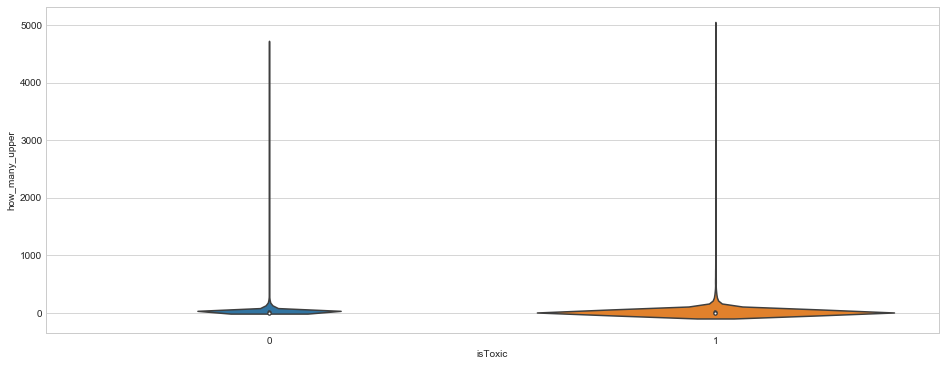

In [14]:
plt.figure(figsize=(16,6))
sns.violinplot('isToxic', 'how_many_upper', data=df)

In [15]:
df.groupby(['isToxic'])['how_many_upper'].mean()

isToxic
0    15.023931
1    47.299271
Name: how_many_upper, dtype: float64

In [16]:
kruskal(df.loc[df['isToxic']==1, 'how_many_upper'], df.loc[df['isToxic']==0, 'how_many_upper'])

KruskalResult(statistic=627.2006018318158, pvalue=2.030798915061655e-138)

In [17]:
def count_punct(txt):
    return sum(1 for t in txt if t in punctuation)

df['how_many_punct'] = df['comment_text'].apply(count_punct)

In [18]:
df.groupby(['isToxic'])['how_many_punct'].mean()

isToxic
0    16.021112
1    13.970452
Name: how_many_punct, dtype: float64

In [19]:
kruskal(df.loc[df['isToxic']==1, 'how_many_punct'], df.loc[df['isToxic']==0, 'how_many_punct'])

KruskalResult(statistic=2340.3287486494637, pvalue=0.0)

In [20]:
df['how_many_upper_cat'] = pd.qcut(df['how_many_upper'], q=3, labels=[0,1,2])

In [21]:
ulim = df['how_many_punct'].quantile(0.99)-1e-5

df.loc[~df['how_many_punct'].between(0,ulim), 'how_many_upper'] = ulim

In [22]:
df['str_len_cat'] = pd.qcut(df['str_len'], 4, range(4))

In [23]:
df['target'] = df.iloc[:,2:8].sum(axis=1)

<br>
## Feature Engineering

### Text stemming and vectorization


In [24]:
drop_cols = ['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 
             'insult', 'identity_hate', 'isToxic', 'str_len', 'how_many_upper']

X = df.drop(drop_cols, axis=1)
y = df['target']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

In [26]:
X_train.shape

(127656, 5)

In [27]:
english_stemmer = nltk.stem.SnowballStemmer('english')

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([english_stemmer.stem(w) for w in analyzer(doc)])

vectorizer_s = StemmedCountVectorizer(min_df=3, max_df=0.99, analyzer="word", stop_words='english')

In [28]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s): 
    return re_tok.sub(r' \1 ', s).split()

class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: ([english_stemmer.stem(w) for w in analyzer(doc)])

tf = StemmedTfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, analyzer='word')

vector_train = tf.fit_transform(X_train['comment_text'])
vector_test = tf.transform(X_test['comment_text'])

In [29]:
vector_train

<127656x334339 sparse matrix of type '<class 'numpy.float64'>'
	with 14069177 stored elements in Compressed Sparse Row format>

In [30]:
svd = TruncatedSVD(n_components=10, random_state=42)
vector_train, vector_test = svd.fit_transform(vector_train), svd.fit_transform(vector_test)

In [31]:
X_train = np.concatenate([X_train.drop('comment_text', axis=1).values, vector_train], axis=1)
X_test = np.concatenate([X_test.drop('comment_text', axis=1).values, vector_test], axis=1)

In [32]:
X_train

array([[9, 1, 1, ..., -0.02413246721921937, -0.0013562341314826349,
        0.0027734539505963047],
       [171, 2, 3, ..., -0.0042212963666413, -0.004817683105552078,
        -0.0034826014801795885],
       [9, 1, 1, ..., -0.010782912242712358, -0.028487781777783043,
        0.0064554394244144015],
       ...,
       [6, 0, 0, ..., 0.0706788999411567, 0.049652417907227894,
        -0.06944346490891519],
       [1, 0, 0, ..., -0.004247172791744611, -0.002718029784568676,
        0.016394365025234326],
       [10, 1, 1, ..., -0.12057885833248079, -0.03385357345187292,
        0.04427723479959908]], dtype=object)

In [33]:
mm = MinMaxScaler()
X_train, X_test = mm.fit_transform(X_train), mm.fit_transform(X_test)

/Users/jimmy/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/jimmy/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [34]:
y_train, y_test = y_train.values, y_test.values

<br>
## Baseline Model - Logistic Regression

In [35]:
lr = LogisticRegression(n_jobs=-1, class_weight='balanced')

def simple_training_acc(preds, X, y, names=None):
    
    acc = {}
    
    for i, pred in enumerate(preds):
        prediction = pred.fit(X, y).predict(X)
        
        if names:
            acc[names[i]] = ((prediction == y).sum())/len(y)
        else:
            acc[i] = ((prediction == y).sum())/len(y)
            
    return acc

simple_training_acc([lr], X_train, y_train, ['Logistic Regression'])

/Users/jimmy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


{'Logistic Regression': 0.9549570721313531}

In [2]:
# Do Cross-validation
kfold = StratifiedKFold(n_splits=3)
lr_acc = cross_val_score(lr, X_train, y_train, scoring='accuracy', 
                               cv=kfold, n_jobs=-1)
print("Cross Validation Accuracy: ", lr_acc.mean())

Cross Validation Accuracy: 0.78


## One More - Learning Curve

In [ ]:
def call_plot(xaxis, train_scores, test_scores, name_pred, name_param):
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    train_scores_std = np.std(train_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.rcParams['font.size'] = 12
    plt.figure(figsize=(10,4))
    plt.plot(xaxis, train_scores_mean, label='Train score')
    plt.plot(xaxis, test_scores_mean, label='Test score')
    plt.fill_between(xaxis, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.15)
    plt.fill_between(xaxis, test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std, alpha=0.15)
    plt.legend(fontsize=14)
    plt.xlabel(name_param)
    plt.ylabel('Accuracy')
    plt.title("{} Accuracy vs. {}".format(name_pred, name_param))
    plt.show()
    
def plot_learning_curve(predictor, X, y, name_param, name_pred, cv=3):
    train_sizes, train_scores, test_scores = learning_curve(predictor, X, y, cv=cv)
    call_plot(train_sizes, train_scores, test_scores, name_pred, name_param)
    
plot_learning_curve(lr, X_train, y_train, "Training Samples", "Logistic Regression")

<br>
## Trying Multiple Models

In [ ]:
def plot_multiple_learning_curve(preds, X, y, title='', figsize=(13, 5), names=[], cv=3):
    '''
    Calling learning curve plots for multiple predictors.
    Learning curves are good indicators of overfitting or underfitting.
    
    '''
    n_pred = len(preds)
    
    train_scores = {}
    test_scores = {}
    
    for i, pred in enumerate(preds):
        train_sizes, train_scores[names[i]], test_scores[names[i]] = learning_curve(pred, X, y, cv=cv)
    

    plt.rcParams['font.size'] = 12
    
    n_col = 2
    n_row = int(np.ceil(n_pred/2)) 
    does_last_exist = bool(n_pred%2) 
    
    fig, axs = plt.subplots(n_row, n_col, figsize=figsize)
    if does_last_exist:
        fig.delaxes(axs[n_row-1, 1])
    
    axs = axs.ravel()
    axs = axs[:-1] if does_last_exist else axs
    
    fig.suptitle(title)
    plt.subplots_adjust(hspace=0.5)
    
    for i, ax in enumerate(axs):
        mean_train_scores = np.mean(train_scores[names[i]], axis=1)
        mean_test_scores = np.mean(test_scores[names[i]], axis=1)
        std_train_scores = np.std(train_scores[names[i]], axis=1)
        std_test_scores = np.std(test_scores[names[i]], axis=1)
        
        ax.plot(train_sizes, mean_train_scores, 'o-', color='r',
                  label='Training score')
        ax.plot(train_sizes, mean_test_scores, 'o-', color='g',
                  label='Test score')
        ax.fill_between(train_sizes, mean_train_scores - std_train_scores,
                          mean_train_scores + std_train_scores, alpha=0.15, color='r')
        ax.fill_between(train_sizes, mean_test_scores - std_test_scores,
                          mean_test_scores + std_test_scores, alpha=0.15, color='g')
        ax.legend(loc='best')
        ax.set_title(names[i])
    
    return plt

predictors = [KNeighborsClassifier(), GaussianNB(), RandomForestClassifier(), 
              XGBClassifier(), SVC(decision_function_shape='ovo')]
pred_names = ['kn', 'nb', 'rf', 'xgb', 'svc']

plot_multiple_learning_curve(predictors, X_train, y_train, figsize=(16, 10), 
                              title='Learning Curve over Predictors', names=pred_names)

<br>
<br><br><br>